<a href="https://colab.research.google.com/github/bademirci/Industrial-Eng.Appl.-in-Python/blob/main/BacktestExcel_backup_20022022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy # for dot product
import pandas # for excel operations
import openpyxl
import pickle
from datetime import datetime # for formatting the dates
from pandas.core.common import flatten # for flattening the beta confidence values
from statsmodels.tsa.vector_ar.vecm import coint_johansen # for the cointegration tests
from statsmodels.tsa.vector_ar.vecm import VECM # for the cointegration model
from random import sample # for sampling a sublist of a list
from matplotlib import pyplot as plt
from scipy import stats
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Step 1:** Test each of the time-series to determine their order of integration. Ideally, this should involve using a test (such as the ADF test) for which the null hypothesis is non-stationarity; as well as a test (such as the KPSS test) for which the null is stationarity. It’s good to have a cross-check

In [ ]:
data = pandas.read_excel('cc_18032022.xlsx',index_col=0);
data = data.iloc[:, :15]
print(data)
data.index = pandas.to_datetime(data.index)
data = data.dropna()

                     ADA-PERP  ATOM-PERP  AVAX-PERP  BCH-PERP  BNB-PERP  \
time                                                                      
2021-03-18T18:00:00  1.309820    23.3630     35.020    539.00  265.9975   
2021-03-19T18:00:00  1.325780    22.4930     37.760    543.00  267.5000   
2021-03-20T18:00:00  1.245610    22.4300     36.104    550.70  271.9375   
2021-03-21T18:00:00  1.217445    21.0485     33.482    528.60  265.6925   
2021-03-22T18:00:00  1.181780    20.5555     32.619    535.05  277.9725   
...                       ...        ...        ...       ...       ...   
2022-03-14T18:00:00  0.791600    26.1440     66.822    282.40  366.2875   
2022-03-15T18:00:00  0.808190    27.7690     70.692    292.25  373.0300   
2022-03-16T18:00:00  0.816500    28.5500     71.458    292.70  378.1200   
2022-03-17T18:00:00  0.841960    28.4945     80.368    297.55  389.3625   
2022-03-18T18:00:00  0.854235    28.3745     85.050    304.15  398.3850   

                     BTC

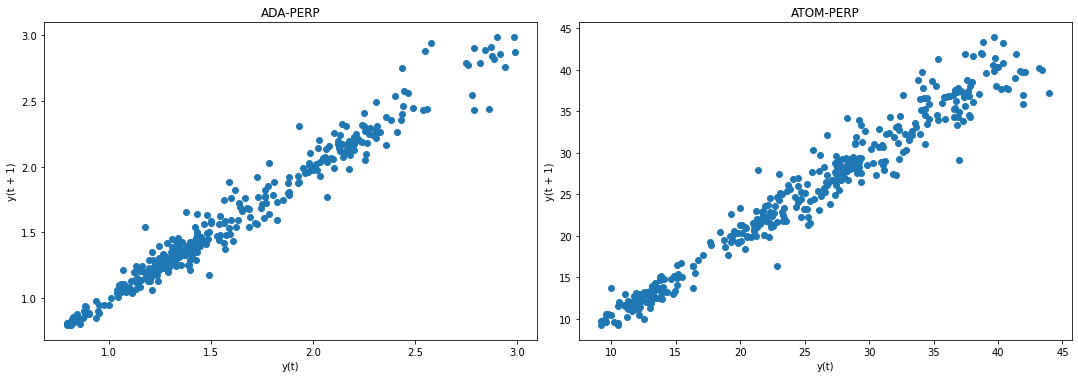

In [ ]:
from pandas.plotting import lag_plot
   
f2, (ax4, ax5) = plt.subplots(1, 2, figsize=(15, 5))
f2.tight_layout()

lag_plot(data[data.columns[0]], ax=ax4)
ax4.set_title(data.columns[0]);

lag_plot(data[data.columns[1]], ax=ax5)
ax5.set_title(data.columns[1]);

plt.show()

Result: Data is not stationary. We will have to make it stationary using difference operation

In [ ]:
level_data = data.copy(deep=True)

for col in data.columns:
  data[col] = data[col].diff(1)
data = data.dropna()

#for col in data.columns:
#  data[col] = data[col].diff(1)
#data = data.dropna()

Split data into train and test. We will need this later for VAR analysis

In [ ]:
train = data.iloc[:round(len(data)*0.8),:]
test = data.iloc[round(len(data)*0.8):,:]

In [ ]:
train.tail()

,ADA-PERP,ATOM-PERP,AVAX-PERP,BCH-PERP,BNB-PERP,BTC-PERP,DOT-PERP,ETH-PERP,FTM-PERP,LTC-PERP,LUNA-PERP,MATIC-PERP,SOL-PERP,WAVES-PERP,XRP-PERP
time,,,,,,,,,,,,,,,
2021-12-31 18:00:00,-0.044115,2.9970,4.320,-1.65,-5.9975,-871.0,-1.260,-38.8,0.04970,-2.09,2.712,-0.018628,-2.3175,-0.1855,-0.029975
2022-01-01 18:00:00,0.020945,4.3525,4.851,11.85,8.0775,815.0,1.023,39.2,0.25785,3.25,1.833,0.008055,2.9100,0.4020,0.021500
2022-01-02 18:00:00,0.032440,-2.1065,1.468,4.90,5.4100,-429.0,2.160,60.4,0.00760,1.66,-0.425,-0.020923,2.1000,0.4065,0.004850
2022-01-03 18:00:00,-0.034110,3.7865,-5.118,-10.70,-11.2050,-701.0,0.010,-55.2,0.22960,-3.81,2.952,-0.092295,-6.3375,-0.0915,-0.020100
2022-01-04 18:00:00,-0.000635,3.4170,-2.035,-5.25,-3.9850,-12.0,-0.221,87.5,0.17515,0.90,-6.085,0.007953,-0.4825,0.8330,-0.005250


In [ ]:
test.head()

,ADA-PERP,ATOM-PERP,AVAX-PERP,BCH-PERP,BNB-PERP,BTC-PERP,DOT-PERP,ETH-PERP,FTM-PERP,LTC-PERP,LUNA-PERP,MATIC-PERP,SOL-PERP,WAVES-PERP,XRP-PERP
time,,,,,,,,,,,,,,,
2022-01-05 18:00:00,-0.029530,-2.3315,-4.710,-7.45,-5.8975,-266.0,-0.617,-85.4,0.06600,-0.88,-3.358,-0.112530,-5.4600,-0.7660,-0.006775
2022-01-06 18:00:00,-0.060545,1.6625,-6.590,-24.65,-28.5400,-3045.0,-2.207,-316.2,0.02730,-10.81,-3.799,-0.097870,-11.1525,-1.2035,-0.051125
2022-01-07 18:00:00,-0.022065,0.5100,-7.332,-10.20,-26.7175,-1387.0,-1.355,-247.2,-0.26485,-3.53,-7.888,-0.131053,-13.9475,-0.3345,-0.007975
2022-01-08 18:00:00,-0.060830,-6.0905,-7.079,-18.15,-18.2175,-669.0,-1.856,-128.9,-0.44895,-5.33,-6.912,-0.162325,-2.0175,-0.6410,-0.021350
2022-01-09 18:00:00,0.026880,0.8520,8.356,5.70,6.0600,949.0,0.993,98.1,0.16845,2.43,8.820,0.149147,6.6450,0.8735,0.016475


ADF Null hypothesis: there is a unit root, i.e. series is non-stationary

In [ ]:
from statsmodels.tsa.stattools import adfuller

Xs = []
for col in data.columns:
  X = numpy.array(data[col])
  X = X[~numpy.isnan(X)]
  Xs.append(X)
  result = adfuller(X)
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Values:')
  for key, value in result[4].items():
      print('\t%s: %.3f' % (key, value))

ADF Statistic: -20.726221
p-value: 0.000000
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571
ADF Statistic: -16.333239
p-value: 0.000000
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571
ADF Statistic: -5.614977
p-value: 0.000001
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
ADF Statistic: -6.456226
p-value: 0.000000
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
ADF Statistic: -12.613339
p-value: 0.000000
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571
ADF Statistic: -20.422477
p-value: 0.000000
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571
ADF Statistic: -19.435710
p-value: 0.000000
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571
ADF Statistic: -19.425792
p-value: 0.000000
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571
ADF Statistic: -18.012072
p-value: 0.000000
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571
ADF Statistic: -6.063654
p-value: 0.000000
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
ADF Statistic: -17.5326

KPSS Null hypothesis: there are no unit roots, i.e. series is stationary

In [ ]:
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

for X in Xs:
  kpss_test(X)

KPSS Statistic: 0.17427192269210942
p-value: 0.1
num lags: 17
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary
KPSS Statistic: 0.0711026320609725
p-value: 0.1
num lags: 17
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary
KPSS Statistic: 0.08405484626501453
p-value: 0.1
num lags: 17
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary
KPSS Statistic: 0.07309251651217494
p-value: 0.1
num lags: 17
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary
KPSS Statistic: 0.10024315551734363
p-value: 0.1
num lags: 17
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary
KPSS Statistic: 0.11043825204892185
p-value: 0.1
num lags: 17
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The se

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-valu

**Result:** ADF Null Hypothesis is rejected: Thus, data is stationary KPSS Null Hypothesis could not be rejected. Thus, data is stationary

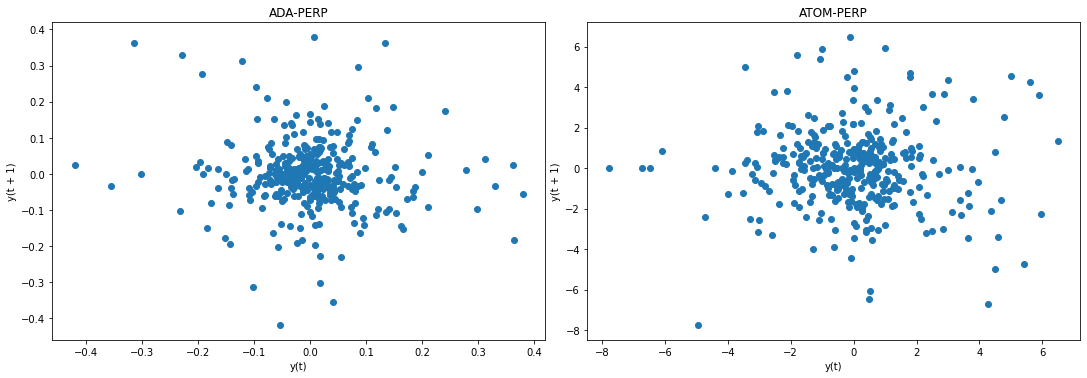

In [ ]:
f2, (ax4, ax5) = plt.subplots(1, 2, figsize=(15, 5))
f2.tight_layout()

lag_plot(data[data.columns[0]], ax=ax4)
ax4.set_title(data.columns[0]);

lag_plot(data[data.columns[1]], ax=ax5)
ax5.set_title(data.columns[1]);

plt.show()

**Result:** lag plot is in confirmatory with ADF test and KPSS test

**Step 2:** Let the maximum order of integration for the group of time-series be m. So, if there are two time-series and one is found to be I(1) and the other is I(2), then m = 2. If one is I(0) and the other is I(1), then m = 1, etc.

**Result:** We saw above that for our case m = 1

**Step 3:** Set up a VAR model in the levels of the data, regardless of the orders of integration of the various time-series. Most importantly, you must not diff() the data, no matter what you find at Step 1.

**Step 4:** Determine the appropriate maximum lag length for the variables in the VAR, say p, using the usual methods. Specifically, base the choice of p on the usual information criteria, such as AIC, SIC.

In [ ]:
# obtain the lag P for VAR
level_data = level_data.dropna()
model = VAR(level_data) #recall that level_data is w/o difference operation
for i in list(range(1, 13)):
    result = model.fit(i)
    try:
        print('Lag Order =', i)
        print('AIC:\t', result.aic)
        print('BIC:\t', result.bic)
        print('FPE:\t', result.fpe)
        print('HQIC:\t', result.hqic, '\n')
    except:
        continue

Lag Order = 1
AIC:	 27.454163959244653
BIC:	 29.99265239533434
FPE:	 838578058511.0337
HQIC:	 28.46247321024072 

Lag Order = 2
AIC:	 27.731093311831568
BIC:	 32.659332985215975
FPE:	 1111851637069.2798
HQIC:	 29.688833081479828 

Lag Order = 3
AIC:	 27.908107357855894
BIC:	 35.23576286692264
FPE:	 1345549750723.2114
HQIC:	 30.81931261855242 

Lag Order = 4
AIC:	 28.27027364694253
BIC:	 38.00707498473526
FPE:	 1985653171483.3037
HQIC:	 32.1390069674233 

Lag Order = 5
AIC:	 28.38351739824246
BIC:	 40.539260567853276
FPE:	 2326633730476.4067
HQIC:	 33.21386920204987 

Lag Order = 6
AIC:	 28.307642241118895
BIC:	 42.892189878489035
FPE:	 2310905911857.482
HQIC:	 34.103731068133925 

Lag Order = 7
AIC:	 28.24937492864029
BIC:	 45.272656932877695
FPE:	 2407735605854.9326
HQIC:	 35.01534769972405 

Lag Order = 8
AIC:	 28.300734785750485
BIC:	 47.77274895707474
FPE:	 2906417950842.8896
HQIC:	 36.04076707053993 

Lag Order = 9
AIC:	 28.23906154716567
BIC:	 50.16987423259267
FPE:	 328149255279

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


**Result:** The lag-order p = 1 on the basis of Akaike Information Criterion (AIC)

**Step 5:** Make sure that the VAR is well-specified. For example, ensure that there is no serial correlation in the residuals. If need be, increase p until any autocorrelation issues are resolved.

In [ ]:
model = VAR(train)
model_fitted = model.fit(1)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


**Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic**

The value of this statistic can vary from 0 to 4. The closer it is to 2, there is less significant serial correlation. The closer it is to 0, there is a positive serial correlation, and being close to 4 implies negative serial correlation.

In [ ]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(data.columns, out):
    print(col, ':', round(val, 2))

ADA-PERP : 2.0
ATOM-PERP : 1.98
AVAX-PERP : 2.01
BCH-PERP : 2.06
BNB-PERP : 2.03
BTC-PERP : 2.06
DOT-PERP : 2.02
ETH-PERP : 2.04
FTM-PERP : 2.0
LTC-PERP : 2.12
LUNA-PERP : 1.94
MATIC-PERP : 2.03
SOL-PERP : 2.01
WAVES-PERP : 2.05
XRP-PERP : 2.05


**Result:** There is no significant correlation between in the residuals

**Step 6:** If two or more of the time-series have the same order of integration, at Step 1, then test to see if they are cointegrated, preferably using Johansen’s methodology (based on your VAR) for a reliable result.

In [ ]:
# I could not perform Johansen's test. Instead I check for co-integration using t-statistics (author's note)

import statsmodels.tsa.stattools as ts 
result = ts.coint(data[data.columns[0]], data[data.columns[1]])
print(result)

(-6.39757072905389, 2.1494044471636264e-07, array([-3.92636618, -3.35273865, -3.05596374]))


**Result:** The p-value (tuple's middle element) < 0.05. Thus rejecting the null hypothesis, they are cointegrated.

**Step 7:** No matter what you conclude about cointegration at Step 6, this is not going to affect what follows. It just provides a possible cross-check on the validity of your results at the very end of the analysis.

**Step 8:** Now take the preferred VAR model and add in m additional lags of each of the variables into each of the equations.

In [ ]:
model = VAR(train)
model_fitted = model.fit(1)
#get the lag order
lag_order = model_fitted.k_ar
print(lag_order)

1


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


**Step 9** and **Step 10:** Test for Granger non-causality. It’s essential that you don’t include the coefficients for the ‘extra’ m lags when you perform the tests. They are there just to fix up the asymptotics.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 370 entries, 2021-03-19 18:00:00 to 2022-03-18 18:00:00
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ADA-PERP    370 non-null    float64
 1   ATOM-PERP   370 non-null    float64
 2   AVAX-PERP   370 non-null    float64
 3   BCH-PERP    370 non-null    float64
 4   BNB-PERP    370 non-null    float64
 5   BTC-PERP    370 non-null    float64
 6   DOT-PERP    370 non-null    float64
 7   ETH-PERP    370 non-null    float64
 8   FTM-PERP    370 non-null    float64
 9   LTC-PERP    370 non-null    float64
 10  LUNA-PERP   370 non-null    float64
 11  MATIC-PERP  370 non-null    float64
 12  SOL-PERP    370 non-null    float64
 13  WAVES-PERP  370 non-null    float64
 14  XRP-PERP    370 non-null    float64
dtypes: float64(15)
memory usage: 46.2 KB


Weed out the columns and return a dictionary {instrument_i:coefficient_i} for the prescribed data slice.

In [ ]:
def weed_out(data, bad, det_order = -1, k_ar_diff = 0):
  n = data.shape[1] # number of trading instruments
  if n <= 2 or ' '.join(list(data.columns)) in bad:
    return False # if there are too few columns or this column is already tried

  coint = coint_johansen(data, det_order = det_order, k_ar_diff = k_ar_diff) # get the cointegration tests
  compare1 = coint.lr1[0] >= coint.cvt[0, 1] # trace statistics test
  compare2 = coint.lr2[0] >= coint.cvm[0, 1] # eigenvalue test

  model = VECM(data, coint_rank = 2, deterministic = "n", k_ar_diff = k_ar_diff).fit() # cointegration model
  
  beta = list(flatten(model.beta)) # cointegration model's beta values
  beta_dict = {model.names[i]: beta[i] for i in range(n)}

  stderr = list(flatten(model.stderr_beta))
  diff = {model.names[i]:abs(beta[i]) - 2 * abs(stderr[i]) for i in range(len(model.names))}

  min_diff = min(diff.values())

  if min_diff >= 0 and compare1 and compare2:
    return beta_dict # no problematic column
  else:
    for instrument in diff: # test each instrument seperately
      if diff[instrument] < 0: # if difference < 0 
        copy = data.copy().drop(columns=instrument) # get a copy of the data without the problematic column
        alt = weed_out(copy, bad) # run again
        if alt != False:
          return alt
        bad.add(' '.join(copy.columns))
  print('No result for', data.columns)
  return False

Find the cointegration coefficients for a slice of a data frame.

In [ ]:
def get_coefficients(data, start, end, bad, det_order = -1, k_ar_diff = 0):
  return weed_out(data.iloc[start:end, :].copy(deep=True), bad)

I wanted to ignore the frequency warning because it hid the necessary information I wanted to see. This is ideally to be removed.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

Create the report of the source data given the lengths of training, testing, and the repetition interval. Report the evolution of the fund given the initial capital.

Entry = 1.1 length = 1 day 0 coefficients: [1.0000000000000002, 1.7720779103755883e-15, 1.8994770271913716e-18, 1.0, -0.03222842086487716, 0, -0.5258905669868538, 0, 0, 0, 0, 0, 0, 0, 0]
No trade at iter = 0
Entry = 1.1 length = 1 day 1 coefficients: [0.9999999999999999, 3.1125527014264175e-16, 1.7526758051242802e-20, 1.0, -0.031231921467565163, 0, -0.4658184097347496, 0, 0, 0, 0, 0, 0, 0, 0]
No trade at iter = 1
Entry = 1.1 length = 1 day 2 coefficients: [1.0, -3.196709826065019e-16, -8.2893274916955545e-19, 1.0, -0.03269439528063312, 0, -0.4476017463609081, 0, 0, 0, 0, 0, 0, 0, 0]
Entry = 1.1 length = 1 day 3 coefficients: [1.0000000000000002, 2.4958879205186863e-16, 1.7084386242339112e-18, 1.0, -0.03313141960869305, 0, -0.46598934651135654, 0, 0, 0, 0, 0, 0, 0, 0]
Entry = 1.1 length = 1 day 4 coefficients: [1.0, 5.342949894776149e-16, 5.197524166000595e-18, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Entry = 1.1 length = 1 day 5 coefficients: [1.0, 1.3434606755567045e-15, 1.34869387521228

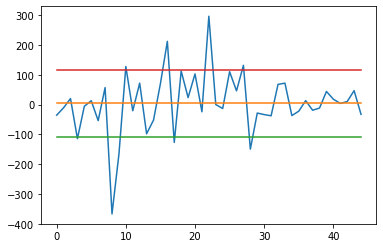

1.1 times the standard deviation: 112.53858731001719
No trade at iter = 39
Sharpe ratio for entry value = 1.1 and testing length = 1 : 6.210434735583774 where 12 number of trades occured.


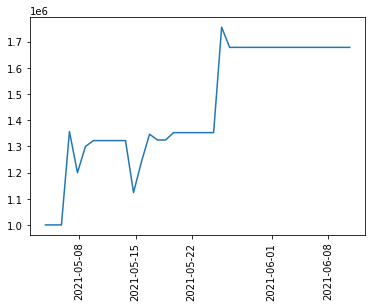

In [ ]:
import math

length_of_training = 45
length_of_testing = 1

capital = 1000000

instruments = list(data.columns)
n = len(instruments)
m = len(data.iloc[:, 0])

# The excel draft.
excel = {'# of training data': [],
          'Training begins': [],
          'Training ends\nTesting begins': [],
          'Testing ends': [],
          'Toplam maliyet': [],
          'Kasa': [],
          'Portföy adedi': [],
          'Kullanılan para': [],
          'Atıl Para': [],
          'Portföy Açılış Endeksi': [],
          'Portföy Kapanış Endeksi': [],
          'Fark': [],
          'P&L': [],
          'P&L%': [],
          'RiskOptima Portföy Değeri': []
          }

# Add each instrument's special columns.
# These are to be turned to multicolumns.
extra_cols = ['Katsayı', 'Portföy Açma', 'Portföy Kapama', 'Maliyet']
for col in extra_cols:
  for instrument in instruments:
    excel[col + ' ' + instrument] = list()

entry_values = [1.1]#, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]

iteration = 40
# Get the coefficients, calculate the opening indices.
# If the last index is positive, then invert the coefficients, thus the opening indices.
# If the last index is below the entry*std_dev line then buy.
# TODO: The code currently works with one week by breaking after the first iteration.
#       This needs to be enhanced to multiple weeks.
for entry in entry_values:
  for length_of_testing in range(1, 2):
    #f, axs = plt.subplots(4, figsize=(10, 10))
    profit_losses = []
    trades = 0
    for i in range(0, m - length_of_training - length_of_testing - 1, length_of_testing):
      if i == iteration*length_of_testing:
        break
      # Calculate the coefficients.
      named_coefficients = get_coefficients(data, i, i + length_of_training, set()) # the coefficient dictionary
      if type(named_coefficients) == bool:
        j = i
        while type(named_coefficients) == bool and j > 0:
          j = j - 1
          #print('No valid models for the training period', j, 'to', i + length_of_training)
          named_coefficients = get_coefficients(data, j, i + length_of_training, set()) # the coefficient dictionary
          continue
        if j == 0:
          #print('No valid models for the training period starting at', i)
          #print('--------------------------------------------------------')
          result = {'# of training data': length_of_training,
            'Training begins': level_data.index[i],
            'Training ends\nTesting begins': level_data.index[i + length_of_training],
            'Testing ends': level_data.index[i + length_of_training + length_of_testing],
            'Toplam maliyet': 0,
            'Kasa': capital,
            'Portföy adedi': 0,
            'Kullanılan para': 0,
            'Atıl Para': capital,
            'Portföy Açılış Endeksi': opening_index,
            'Portföy Kapanış Endeksi': closing_index,
            'Fark': 0,
            'P&L': 0,
            'P&L%': 0, # ratio of profit or loss to the overall money
            'RiskOptima Portföy Değeri': capital
          }
          for column_name in result.keys(): # move the results to excel
            excel[column_name].append(result[column_name])

          extra_cols_dict = {'Katsayı': coefficients, 'Portföy Açma': opening, 'Portföy Kapama': closing, 'Maliyet': cost_of_opening}
          for col in extra_cols_dict:
            for instrument in instruments: # for those columns that are to be turned into multicolumns, appending is somewhat manual
              excel[col + ' ' + instrument].append(extra_cols_dict[col][instruments.index(instrument)])

          capital = result['RiskOptima Portföy Değeri'] # the new capital
          continue

      coefficients = [named_coefficients.get(instrument, 0) for instrument in instruments] # copy the dictionary, setting 0 those dropped
      print('Entry =', entry, 'length =', length_of_testing, 'day', i, 'coefficients:', coefficients)
      opening_indices = []
      for j in range(i, i + length_of_training):
        opening = data.iloc[j, :] # prices
        opening_indices.append(numpy.dot(opening, coefficients)) # calculate the account opening index
      std_dev = numpy.std(opening_indices)
      mean = numpy.mean(opening_indices)
      if opening_indices[-1] > mean:
        #print("Inverting the coefficients at iter =", i)
        coefficients = [-c for c in coefficients]
        opening_indices = [-o for o in opening_indices]
      mean = numpy.mean(opening_indices)

      #for j in range(len(opening_indices)):
      #  print('Day', j, ':', opening_indices[j])

      if i == iteration - 1:
        plt.plot(opening_indices)
        mean_line = [mean for j in range(len(opening_indices))]
        plt.plot(mean_line)
        bottom_line = [z - entry*std_dev for z in mean_line]
        plt.plot(bottom_line)
        top_line = [z + entry*std_dev for z in mean_line]
        plt.plot(top_line)
        plt.show()
        print(entry, 'times the standard deviation:', entry*std_dev)
      
      # Decide whether the trade will take place.
      if opening_indices[-1] >= mean-entry*std_dev:
        print('No trade at iter =', i)
        #print('--------------------------------------------------------')
        result = {'# of training data': length_of_training,
          'Training begins': level_data.index[i],
          'Training ends\nTesting begins': level_data.index[i + length_of_training],
          'Testing ends': level_data.index[i + length_of_training + length_of_testing],
          'Toplam maliyet': 0,
          'Kasa': capital,
          'Portföy adedi': 0,
          'Kullanılan para': 0,
          'Atıl Para': capital,
          'Portföy Açılış Endeksi': opening_index,
          'Portföy Kapanış Endeksi': closing_index,
          'Fark': 0,
          'P&L': 0,
          'P&L%': 0, # ratio of profit or loss to the overall money
          'RiskOptima Portföy Değeri': capital
          }
        for column_name in result.keys(): # move the results to excel
          excel[column_name].append(result[column_name])

        extra_cols_dict = {'Katsayı': coefficients, 'Portföy Açma': opening, 'Portföy Kapama': closing, 'Maliyet': cost_of_opening}
        for col in extra_cols_dict:
          for instrument in instruments: # for those columns that are to be turned into multicolumns, appending is somewhat manual
            excel[col + ' ' + instrument].append(extra_cols_dict[col][instruments.index(instrument)])

        capital = result['RiskOptima Portföy Değeri'] # the new capital
        continue

      opening = level_data.iloc[i + length_of_training, :] # prices at the day testing begins

      cost_of_opening = [opening[i] * abs(coefficients[i]) for i in range(n)] # the cost of opening one account for each instrument
      cost = sum(cost_of_opening) # the total cost of opening an account

      while cost > 100:
        coefficients = [c / 10 for c in coefficients]
        cost_of_opening = [c / 10 for c in cost_of_opening]
        cost = cost / 10

      opening_index = numpy.dot(opening, coefficients) # calculate the account opening index

      closing = level_data.iloc[i + length_of_training + length_of_testing, :] # prices at the day testing ends
      closing_index = numpy.dot(closing, coefficients) # calculate the account closing index

      difference = closing_index - opening_index # profit or loss per account

      count = capital // cost # number of accounts that can be created

      # Calculate profit or loss.
      profit_and_loss = difference * count # profit or loss multiplied with the number of accounts
      #print('PL:', profit_and_loss)
      profit_losses.append(profit_and_loss)
      trades = trades + 1
      #print('--------------------------------------------------------')

      # Record the results in a dictionary to be appended to the respectice column in excel.
      result = {'# of training data': length_of_training,
                'Training begins': level_data.index[i],
                'Training ends\nTesting begins': level_data.index[i + length_of_training],
                'Testing ends': level_data.index[i + length_of_training + length_of_testing],
                'Toplam maliyet': cost,
                'Kasa': capital,
                'Portföy adedi': count,
                'Kullanılan para': count * cost,
                'Atıl Para': capital - count * cost,
                'Portföy Açılış Endeksi': opening_index,
                'Portföy Kapanış Endeksi': closing_index,
                'Fark': difference,
                'P&L': profit_and_loss,
                'P&L%': profit_and_loss / capital * 100, # ratio of profit or loss to the overall money
                'RiskOptima Portföy Değeri': capital + profit_and_loss
                }

      for column_name in result.keys(): # move the results to excel
        excel[column_name].append(result[column_name])

      extra_cols_dict = {'Katsayı': coefficients, 'Portföy Açma': opening, 'Portföy Kapama': closing, 'Maliyet': cost_of_opening}
      for col in extra_cols_dict:
        for instrument in instruments: # for those columns that are to be turned into multicolumns, appending is somewhat manual
          excel[col + ' ' + instrument].append(extra_cols_dict[col][instruments.index(instrument)])

      capital = result['RiskOptima Portföy Değeri'] # the new capital
    if len(profit_losses) > 0:
      mean_pl = numpy.mean(profit_losses)
      std_pl = numpy.std(profit_losses)
      sharpe = mean_pl / std_pl * math.sqrt(360)
      print('Sharpe ratio for entry value =', entry,
            'and testing length =', length_of_testing, ':',
            sharpe, 'where', trades, 'number of trades occured.')
      #axs[0].plot(sharpe)
      #axs[1].plot(mean_pl)
      #axs[2].plot(std_pl)
      #axs[3].plot(trades)
      #plt.show()

pandas.DataFrame(excel).to_excel('report.xlsx') # write to excel

plt.plot(excel['Testing ends'], excel['Kasa'])
plt.xticks(rotation = 90)
plt.savefig('graph.png')
plt.show()

wb = openpyxl.load_workbook('report.xlsx')
ws = wb.active
img = openpyxl.drawing.image.Image('graph.png')
cols = 15 + 4 * n
img.anchor = chr(ord('A') + (cols - 25) // 25) + chr(ord('A') + cols % 25) + '1'
ws.add_image(img)
wb.save('out.xlsx')